In [2]:
import c2qa
import numpy as np
from qiskit import ClassicalRegister, visualization, AncillaRegister
from qiskit.quantum_info.operators.predicates import is_unitary_matrix
from math import pi

# Bosonic Error Correction


/Users/benjamin/Code Projects/HvA/exploring-bosonic-qiskit-qec/c2qa/kraus.py:185: UserWarning: PhotonLossNoisePass ignores instructions without duration, you may need to schedule circuit in advance.
  warnings.warn(


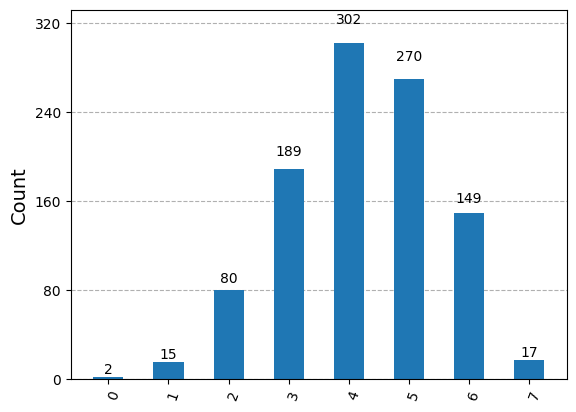

In [3]:
num_qumodes = 1
num_qubits_per_qumode = 3

photon_loss_rate = 0.5 # loss rate in units of 1/ms
circuit_delay = 1 # large enough for on average 2 photons to be lost
time_unit = "ms"

qmr = c2qa.QumodeRegister(num_qumodes, num_qubits_per_qumode)
cr = ClassicalRegister(num_qumodes * num_qubits_per_qumode)
circuit = c2qa.CVCircuit(qmr, cr)

# to illustrate photon loss, initialise the qumode in Fock state |7>
circuit.cv_initialize(7, qmr[0])

# apply a delay to illustrate the effect of photon loss
circuit.cv_delay(duration=circuit_delay, unit=time_unit, qumode=qmr[0])

noise_pass = c2qa.kraus.PhotonLossNoisePass(photon_loss_rates=photon_loss_rate, circuit=circuit, time_unit=time_unit)

circuit.cv_measure(qmr[0], cr)

# circuit.draw('mpl')

counts = c2qa.util.simulate(circuit, noise_passes=noise_pass)[2] # Returns a tuple of state, result, fock_counts

visualization.plot_histogram(counts)

### bla

In [4]:
# Create a new circuit with 1 qumode, 1 ancilla qubit, and 1 classical register for ancilla readout.
qmr = c2qa.QumodeRegister(num_qumodes, num_qubits_per_qumode)
anc = AncillaRegister(1)
cr = ClassicalRegister(1)
circuit = c2qa.CVCircuit(qmr, anc, cr)

circuit.initialize([1, 0], anc[0]) # Initialise ancilla qubit in |0> (even) state

# Initialise qumode in either odd parity or even parity Fock state
# circuit.cv_initialize(2, qmr) # |2> (even) Fock state
circuit.cv_initialize(3, qmr) # |3> (odd) Fock state

circuit.h(anc)

circuit.cv_c_r(pi/2, qmr[0], anc)
circuit.cv_r(-pi/2, qmr[0])

circuit.h(anc)
circuit.cv_measure(anc, cr)

counts = c2qa.util.simulate(circuit)[2]

# Measurement will return 0 for even parity and 1 for odd parity
print(counts)

{'1': 1024}


/Users/benjamin/Code Projects/HvA/exploring-bosonic-qiskit-qec/.venv/lib/python3.12/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


### bla

In [5]:
empty = np.zeros((2**num_qubits_per_qumode, 2**num_qubits_per_qumode))

# map logical |1> photon loss (fock state |1>) back to logical state |1>. (where fock_input = |1>, and fock_output = |2>)
u_odd = c2qa.util.fockmap(matrix=empty, fock_input=[1], fock_output=[2])

# map logical |0> photon loss (fock state |3>) back to logical state |0> ((|0> + |4>)/sqrt(2))
u_odd = c2qa.util.fockmap(matrix=u_odd, fock_input=[3, 3], fock_output=[0, 4], amplitude=[1/np.sqrt(2), 1/np.sqrt(2)]) 

# satisfy unitary condition
u_odd = c2qa.util.fockmap(u_odd, [5, 6, 7], [5, 6, 7])
u_odd = c2qa.util.fockmap(u_odd, [2, 0], [3, 1])
u_odd = c2qa.util.fockmap(u_odd, [4, 4], [0, 4], 1/np.sqrt(2) * np.array([1, -1]))

assert(is_unitary_matrix(u_odd))

def u_even(kt):
    # map logical |1> photon loss (fock state |2>) back to logical state |1>
    u_even = c2qa.util.fockmap(matrix=empty, fock_input=[2], fock_output=[2])

    # map logical |0> photon loss (fock state |0> or |4>) back to logical state |0> 
    # (fock_input = |0>, fock_output = (|0> + |4>) * amplitude. fock_input = |4>, fock_output = (|0> + |4>) * amplitude)
    u_even = c2qa.util.fockmap(matrix=u_even, fock_input=[0, 0, 4, 4], fock_output=[0, 4, 0, 4], amplitude=(1/np.sqrt(1 + kt**2) * np.array([1, kt, -kt, 1])))

    # satisfy unitary condition
    u_even = c2qa.util.fockmap(u_even, [1, 3, 5, 6, 7], [1, 3, 5, 6, 7]) 

    assert(is_unitary_matrix(u_even))
    return u_even

### bla

In [7]:
qmr = c2qa.QumodeRegister(num_qumodes, num_qubits_per_qumode)
cr = ClassicalRegister(num_qumodes * num_qubits_per_qumode)
circuit = c2qa.CVCircuit(qmr, cr)

# initialise qumode in |1_L> error state (|1>)
circuit.cv_initialize([0, 1], qmr) # (0 * |0> + 1 * |1>) = |1>

# append the u_odd matrix to circuit and measure
circuit.cv_gate_from_matrix(u_odd, qmr[0])
circuit.cv_measure(qmr[0], cr)

counts = c2qa.util.simulate(circuit)[2]

# We measure |2> Fock state, demonstrating recovery of the logical |1> state
print(counts)

{'2': 1024}


# -this-

/Users/benjamin/Code Projects/HvA/exploring-bosonic-qiskit-qec/c2qa/kraus.py:185: UserWarning: PhotonLossNoisePass ignores instructions without duration, you may need to schedule circuit in advance.
  warnings.warn(
/Users/benjamin/Code Projects/HvA/exploring-bosonic-qiskit-qec/.venv/lib/python3.12/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


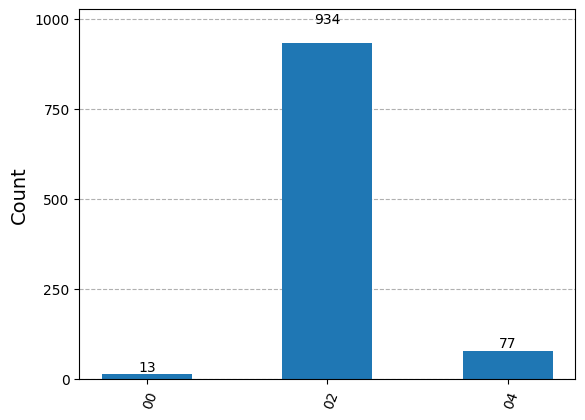

In [20]:
num_qumodes = 1
num_qubits_per_qumode = 3

photon_loss_rate = 0.75 # loss rate in units of 1/ms
circuit_delay = 0.5
time_unit = "ms"

# create circuit
qmr = c2qa.QumodeRegister(num_qumodes, num_qubits_per_qumode)
anc = AncillaRegister(1)
cr = ClassicalRegister(num_qumodes * num_qubits_per_qumode + 1)
circuit = c2qa.CVCircuit(qmr, anc, cr)


def do_error_correction(circuit):
    # photon parity measurement
    circuit.h(anc[0])
    circuit.cv_c_r(pi/2, qmr[0], anc[0])
    
    circuit.cv_r(-pi/2, qmr[0])
    
    circuit.h(anc[0])
    circuit.measure(anc[0], cr[0])
            
    kt_dur = circuit_delay # time since previous error correction
    kt = photon_loss_rate * (kt_dur + 3)
            
    with circuit.if_test((cr[0], 1), label='Recovery operator') as else_:
        circuit.cv_gate_from_matrix(u_odd, qmr[0], duration=0.1, unit="ns")
        circuit.reset(anc[0])
    with else_:
        circuit.cv_gate_from_matrix(u_even(kt), qmr[0], duration=0.1, unit="ns")
    

# initialise ancilla qubit in even |0> or odd |1> state
circuit.initialize(0, anc[0]) 
# initialise qumode in Fock state even or odd
circuit.cv_initialize(2, qmr[0])

# apply a delay to illustrate the effect of photon loss
circuit.cv_delay(duration=circuit_delay, unit=time_unit, qumode=qmr[0])

# apply error correction
do_error_correction(circuit)

noise_pass = c2qa.kraus.PhotonLossNoisePass(photon_loss_rates=photon_loss_rate, circuit=circuit, time_unit=time_unit)

# to see the loss and correction, add measurements and count up the results
circuit.cv_measure(qmr[0], cr)

# circuit.draw('mpl')

counts = c2qa.util.simulate(circuit, noise_passes=noise_pass)[2] # returns a tuple of state, result, fock_counts

visualization.plot_histogram(counts)o


# WIP

### Detailed Documentation

This section provides detailed documentation for simulating photon loss in a qumode using Bosonic Qiskit and the `c2qa` package. This serves as the first step in demonstrating the binomial 'kitten' code for error correction.

#### Setup and Initialization

First, we define the number of qumodes and the number of qubits per qumode. We also set the photon loss rate and the duration for which the delay (representing photon loss) is applied:

```python
num_qumodes = 1
num_qubits_per_qumode = 3

photon_loss_rate = 0.5  # loss rate in units of 1/ms
circuit_delay = 1  # duration in ms
time_unit = "ms"
```

- `num_qumodes`: Number of qumodes in the register.
- `num_qubits_per_qumode`: Number of qubits used to represent each qumode.
- `photon_loss_rate`: The rate at which photons are lost.
- `circuit_delay`: The time duration for which the delay is applied, during which photon loss occurs.
- `time_unit`: The unit of time for the delay (milliseconds in this case).

#### Creating Qumode and Classical Registers

We create a qumode register and a classical register:

```python
qmr = c2qa.QumodeRegister(num_qumodes, num_qubits_per_qumode)
cr = ClassicalRegister(num_qumodes * num_qubits_per_qumode)
```

- `qmr`: Qumode register containing the qumodes.
- `cr`: Classical register for storing measurement results.

#### Building the Quantum Circuit

We create a continuous-variable (CV) quantum circuit that includes both the qumode and classical registers:

```python
circuit = c2qa.CVCircuit(qmr, cr)
```

#### Initializing the Qumode

To illustrate photon loss, we initialize the qumode in a specific Fock state, \(|7\rangle\):

```python
circuit.cv_initialize(7, qmr[0])
```

This command initializes the first qumode (`qmr[0]`) in the Fock state with 7 photons.

#### Applying Photon Loss

We apply a delay to simulate the effect of photon loss:

```python
circuit.cv_delay(duration=circuit_delay, unit=time_unit, qumode=qmr[0])
```

This command applies a delay of `circuit_delay` milliseconds to the specified qumode (`qmr[0]`), during which photon loss can occur.

#### Adding Photon Loss Noise

We create a noise pass to simulate photon loss during the delay:

```python
noise_pass = c2qa.kraus.PhotonLossNoisePass(photon_loss_rates=photon_loss_rate, circuit=circuit, time_unit=time_unit)
```

- `photon_loss_rates`: The rate at which photons are lost.
- `circuit`: The quantum circuit to which the noise pass is applied.
- `time_unit`: The unit of time for the noise pass (milliseconds in this case).

#### Measuring the Qumode

We measure the qumode and store the results in the classical register:

```python
circuit.cv_measure(qmr[0], cr)
```

This command measures the state of the first qumode (`qmr[0]`) and stores the result in the classical register (`cr`).

#### Simulating the Circuit

We simulate the circuit with the photon loss noise pass and visualize the results:

```python
counts = c2qa.util.simulate(circuit, noise_passes=noise_pass)[2]  # Returns a tuple of state, result, fock_counts
qiskit.visualization.plot_histogram(counts)
```

- `c2qa.util.simulate`: Simulates the quantum circuit with the specified noise passes.
- `counts`: The resulting photon number distribution after simulation.
- `qiskit.visualization.plot_histogram`: Plots a histogram of the photon number distribution.

### Code Overview

Here's the complete code snippet with detailed comments:

```python
from qiskit import Aer
import c2qa
import qiskit.visualization
from qiskit import ClassicalRegister

# Define parameters
num_qumodes = 1
num_qubits_per_qumode = 3

photon_loss_rate = 0.5  # loss rate in units of 1/ms
circuit_delay = 1  # duration in ms
time_unit = "ms"

# Create qumode and classical registers
qmr = c2qa.QumodeRegister(num_qumodes, num_qubits_per_qumode)
cr = ClassicalRegister(num_qumodes * num_qubits_per_qumode)

# Create the quantum circuit
circuit = c2qa.CVCircuit(qmr, cr)

# Initialize the qumode in Fock state |7>
circuit.cv_initialize(7, qmr[0])

# Apply a delay to simulate photon loss
circuit.cv_delay(duration=circuit_delay, unit=time_unit, qumode=qmr[0])

# Create a noise pass for photon loss
noise_pass = c2qa.kraus.PhotonLossNoisePass(photon_loss_rates=photon_loss_rate, circuit=circuit, time_unit=time_unit)

# Measure the qumode
circuit.cv_measure(qmr[0], cr)

# Simulate the circuit and plot the results
counts = c2qa.util.simulate(circuit, noise_passes=noise_pass)[2]  # Returns a tuple of state, result, fock_counts
qiskit.visualization.plot_histogram(counts)
```

### Summary

In this example, we demonstrated how to initialize a qumode in a Fock state, apply a delay to simulate photon loss, and measure the resulting state. This setup is essential for studying and implementing error correction techniques, such as the binomial 'kitten' code, which will be used to correct for photon loss errors in subsequent steps.

---

### Introduction to Error Correction with the Binomial 'Kitten' Code

Quantum error correction is essential for reliable quantum computation, especially in the presence of noise and decoherence. In the context of bosonic systems, photon loss is a significant source of errors. The binomial 'kitten' code is a quantum error correction code designed to protect against such errors by encoding logical qubit information into bosonic qumodes. 

#### Understanding Photon Loss

Photon loss is a common error in quantum systems that use bosonic modes (such as optical or microwave cavities) to encode information. This type of error occurs when photons leak out of the system, leading to a loss of quantum information. The rate of photon loss is typically proportional to the number of photons in the system.

#### Binomial Codes

Binomial codes are a family of quantum error-correcting codes that are particularly well-suited for correcting photon loss errors. They encode logical qubits into superpositions of Fock states (states with a definite number of photons). The simplest binomial code is the 'kitten' code, which can correct single-photon loss errors.

### Logical States in the 'Kitten' Code

In the 'kitten' code, the logical qubit states are defined as superpositions of Fock states with specific properties. For the 'kitten' code, the logical states are:

\[
\begin{align*}
\ket{0_L} &= \frac{1}{\sqrt{2}} (\ket{0} + \ket{4}) \\
\ket{1_L} &= \ket{2}
\end{align*}
\]

These states have several important properties:
- **Photon Number Parity**: Both logical states have even photon number parity. This means that single-photon loss errors, which change the photon number by one, will map these states onto odd parity Fock states.
- **Error Detection**: By measuring the photon number parity (whether the photon number is even or odd), we can detect the occurrence of a single-photon loss error without collapsing the logical state.
- **Logical Information Protection**: The logical information is distributed across multiple Fock states, providing redundancy that helps protect against errors.

### Error Correction Procedure

The error correction procedure for the 'kitten' code involves two main steps:
1. **Error Detection**: Measure the photon number parity to determine if an error has occurred. If the parity is odd, a photon loss error is detected.
2. **Error Recovery**: Apply a recovery operation to correct the error and restore the logical state.

### Simulation in Bosonic Qiskit

Using Bosonic Qiskit and the `c2qa` package, we can simulate the process of encoding, introducing errors (photon loss), and correcting errors in a qumode.

#### Example: Simulating Photon Loss

Here's an example of initializing a qumode in a Fock state, applying a delay to simulate photon loss, and measuring the resulting state:

```python
from qiskit import Aer
import c2qa
import qiskit.visualization
from qiskit import ClassicalRegister

# Define parameters
num_qumodes = 1
num_qubits_per_qumode = 3

photon_loss_rate = 0.5  # loss rate in units of 1/ms
circuit_delay = 1  # duration in ms
time_unit = "ms"

# Create qumode and classical registers
qmr = c2qa.QumodeRegister(num_qumodes, num_qubits_per_qumode)
cr = ClassicalRegister(num_qumodes * num_qubits_per_qumode)

# Create the quantum circuit
circuit = c2qa.CVCircuit(qmr, cr)

# Initialize the qumode in Fock state |7>
circuit.cv_initialize(7, qmr[0])

# Apply a delay to simulate photon loss
circuit.cv_delay(duration=circuit_delay, unit=time_unit, qumode=qmr[0])

# Create a noise pass for photon loss
noise_pass = c2qa.kraus.PhotonLossNoisePass(photon_loss_rates=photon_loss_rate, circuit=circuit, time_unit=time_unit)

# Measure the qumode
circuit.cv_measure(qmr[0], cr)

# Simulate the circuit and plot the results
counts = c2qa.util.simulate(circuit, noise_passes=noise_pass)[2]  # Returns a tuple of state, result, fock_counts
qiskit.visualization.plot_histogram(counts)
```

### Summary

The binomial 'kitten' code provides a robust method for correcting single-photon loss errors in bosonic quantum systems. By encoding logical qubit states into superpositions of Fock states and utilizing parity measurements, we can detect and correct errors without collapsing the logical state. This error correction capability is crucial for the development of reliable and scalable quantum computers using bosonic modes.

Bosonic Qiskit, with its `c2qa` package, offers powerful tools for simulating these error correction processes, allowing researchers to explore and develop quantum error correction techniques tailored to bosonic systems.